## Vehicle Detection Project

In this notebook we will put together all the buildings blocks in creating a pipeline for detecting vehicles in a given video.

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import time
import glob
import pickle

from helper_functions import *

%matplotlib inline

Let's import the already trained model.

In [2]:
dist_pickle = pickle.load(open("dist_pickle.p", "rb" ))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
color_space = dist_pickle["color_space"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]

Let's try it out and see that everything was properly imported.

Ok, seems like everything is still running, let's go ahead and build the rest of the pipeline now.

So we need to do the following, for each image:

1) Split it into windows

2) For each window, calculate the Spatial, Histogram and HoG features

3) Pass these to the classifier and only save the images that the classifier says are labeled as "cars"

4) Now that we have the boxed windows, apply heatmap to them in order to only extract the ones above a certain threshold

5) Once we separated the false positives through heatmap detection, label the heatmap in order to identify the cars on the image

6) This will allow us to mark the cars given the labels from the image

Optimizations:

For 2), we can pre-calculate the HoG features for the entire area of interest and then use portions of it for each window, instead of calculating for each window individually.

For 4-6, it would be better to average the window positions over, let's say, last 5 frames, for smoother transitions.

In [3]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return windows

In [4]:
def process_single_image(img):
    start = time.time()
    
    windows1 = find_cars(img, 350, 550, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    windows2 = find_cars(img, 500, 660, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    end_windows = time.time()
    
    print("Time to get windows: ", round(end_windows - start, 2))
    
    windows = windows1 + windows2
    
    print("Number of predicted car windows: ", len(windows))
    
    window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
    
    # Add heat to each box in box list
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    end = time.time()
    
    print("Total time to mark cars: ", round(end - start, 2))
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    ax1.imshow(img)
    ax1.set_title("Original Image", fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title("Detection Windows Image", fontsize=30)
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title("Heatmap Image", fontsize=30)
    ax4.imshow(result)
    ax4.set_title("Detection Boxes Image", fontsize=30)
    plt.show()
    
    return result

/usr/local/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time to get windows:  2.48
Number of predicted car windows:  7
Total time to mark cars:  2.51


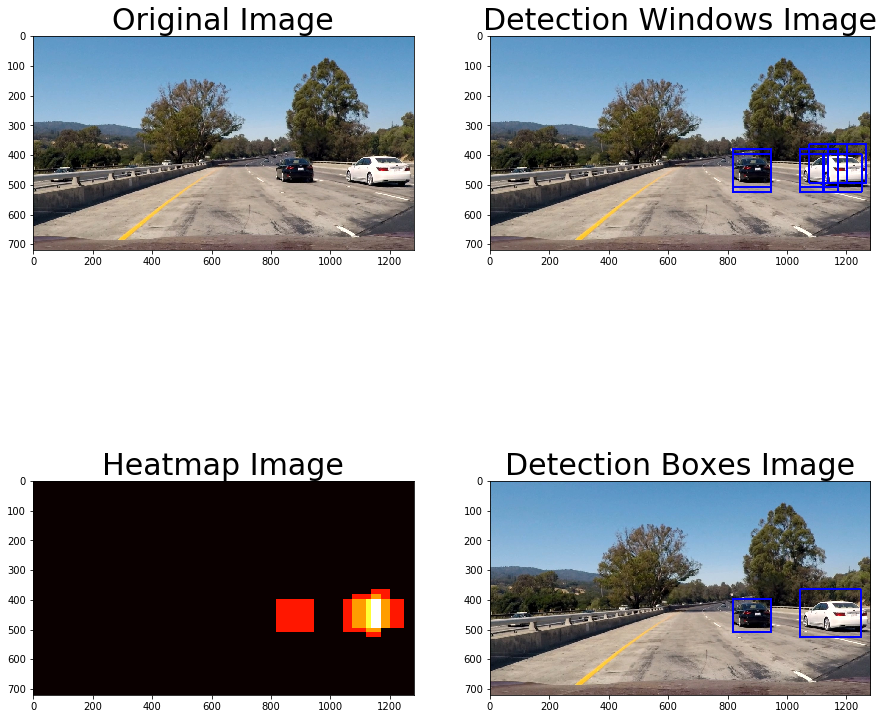

Time to get windows:  2.41
Number of predicted car windows:  0
Total time to mark cars:  2.42


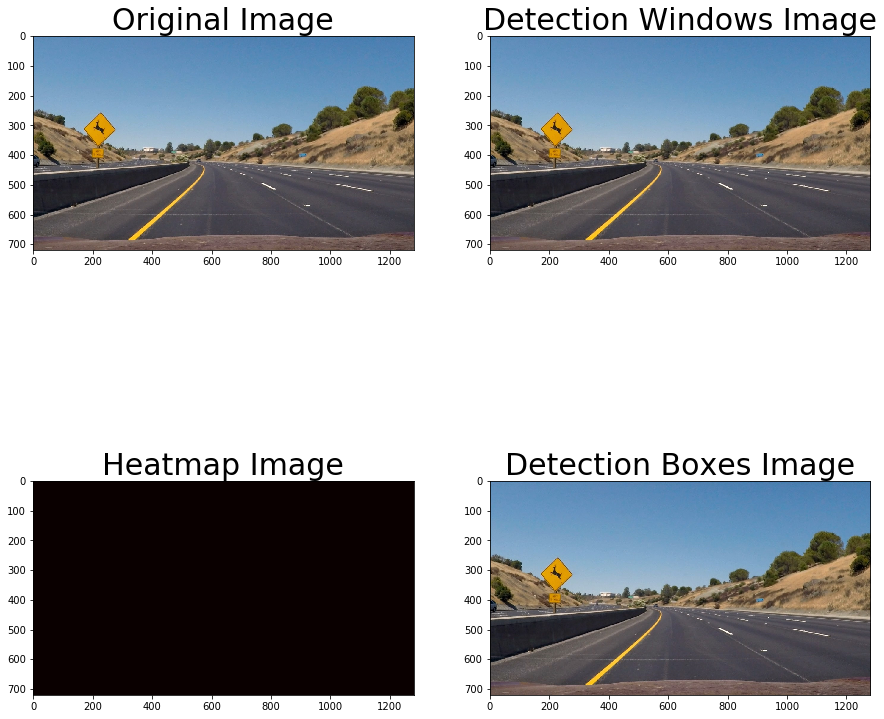

Time to get windows:  2.45
Number of predicted car windows:  0
Total time to mark cars:  2.47


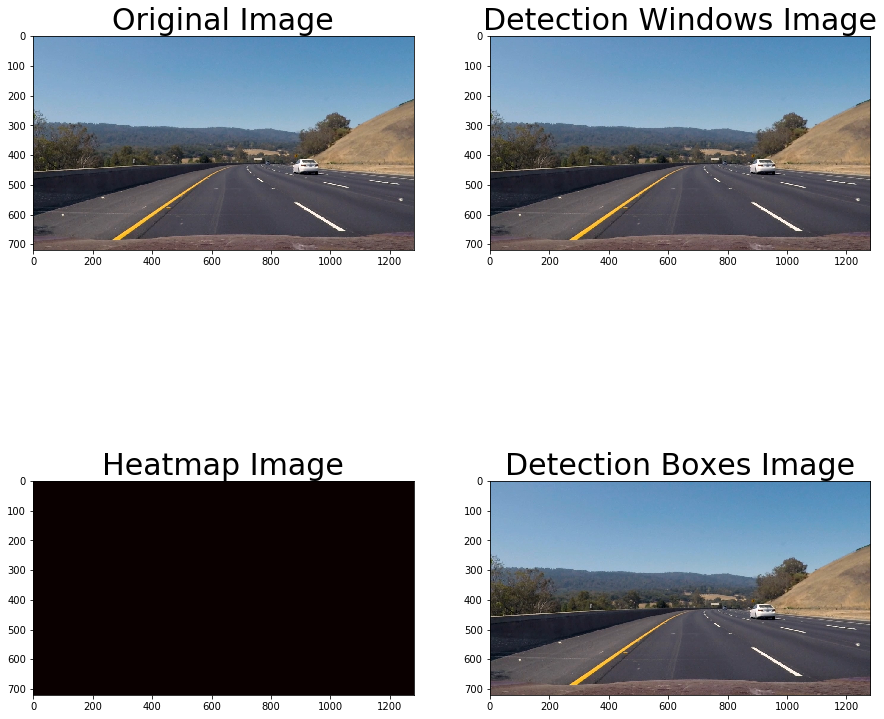

Time to get windows:  2.43
Number of predicted car windows:  2
Total time to mark cars:  2.45


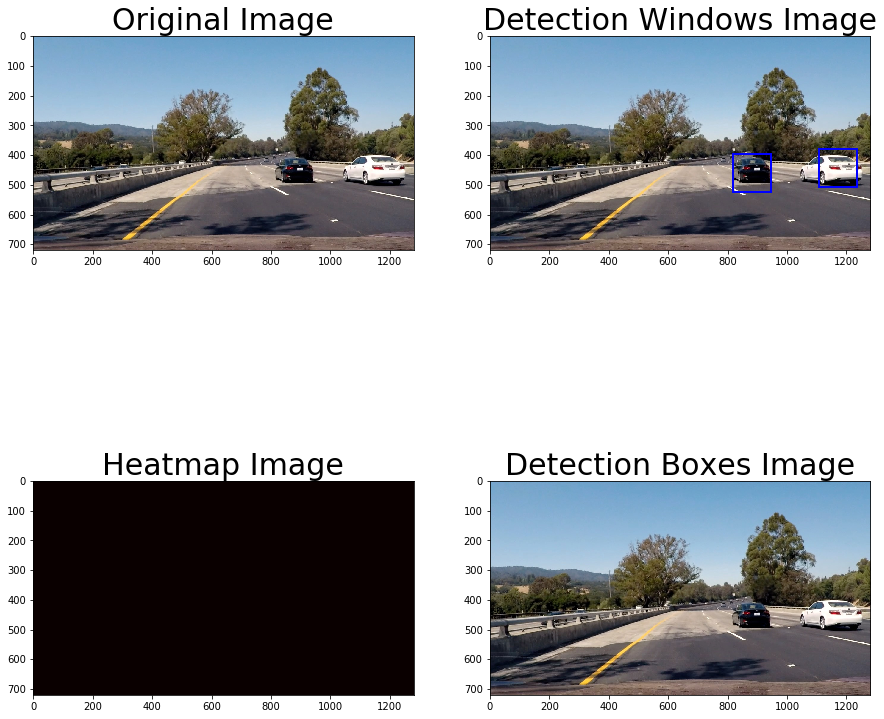

Time to get windows:  2.49
Number of predicted car windows:  13
Total time to mark cars:  2.53


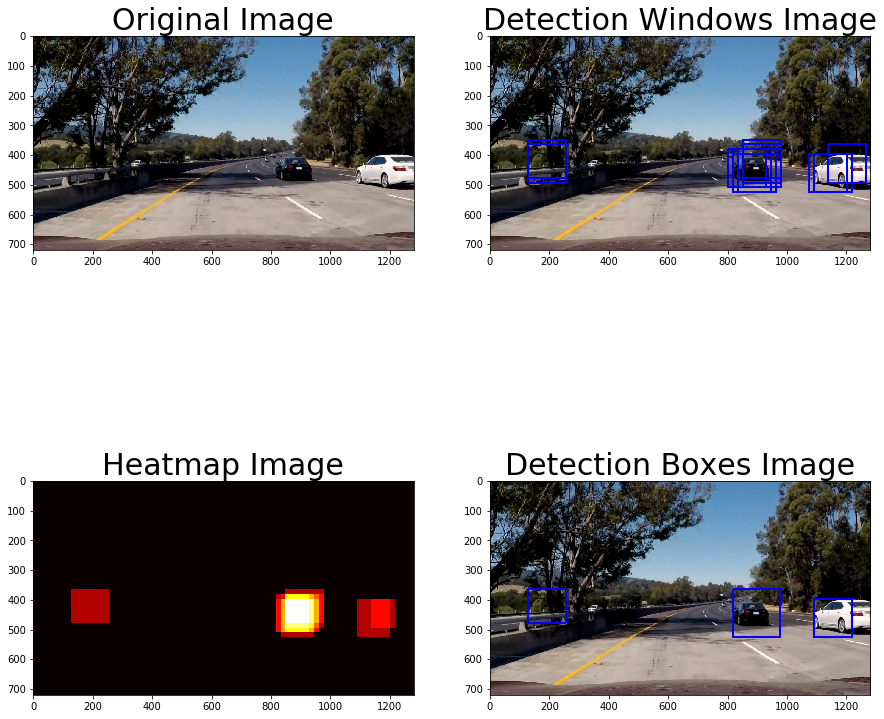

Time to get windows:  2.36
Number of predicted car windows:  5
Total time to mark cars:  2.38


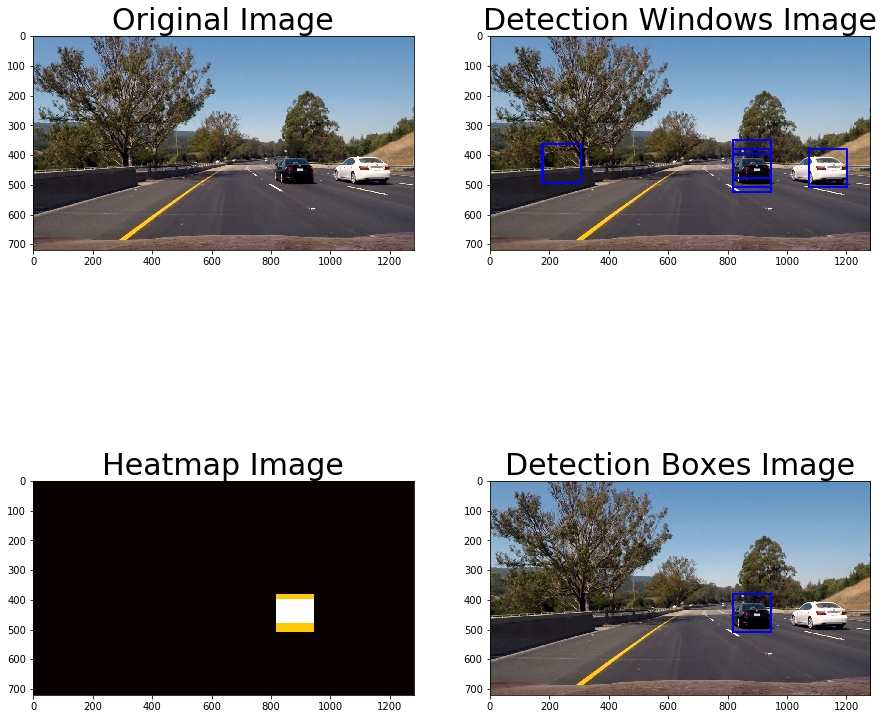

Time to get windows:  2.41
Number of predicted car windows:  4
Total time to mark cars:  2.44


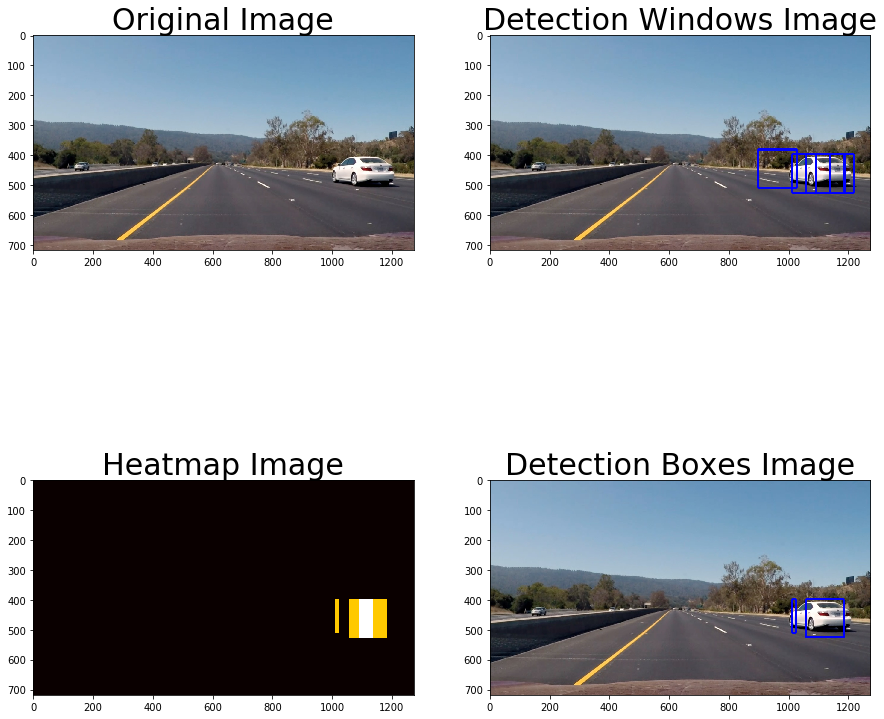

Time to get windows:  2.35
Number of predicted car windows:  0
Total time to mark cars:  2.37


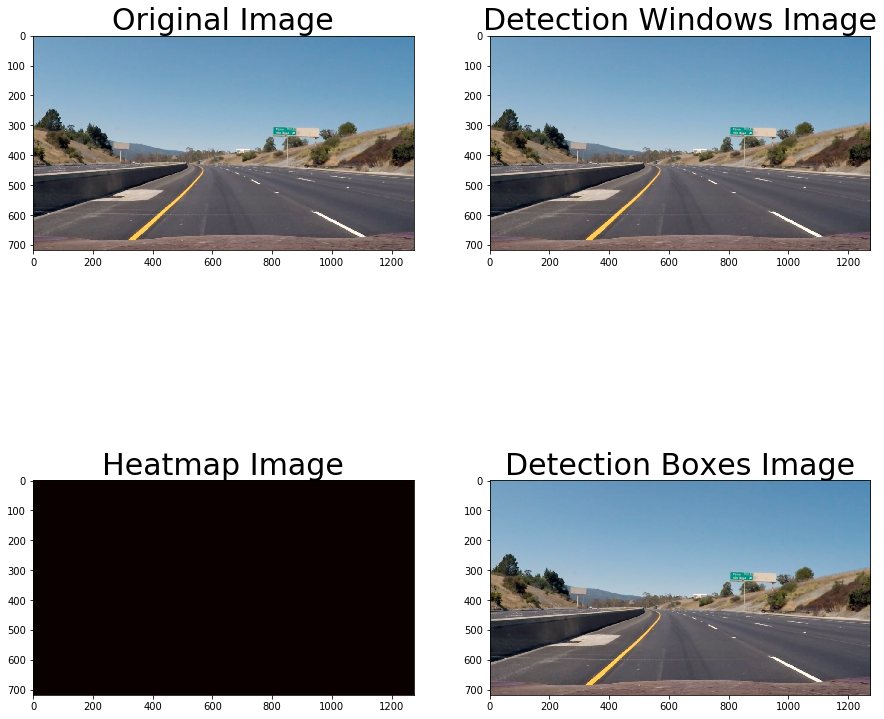

Time to get windows:  2.5
Number of predicted car windows:  0
Total time to mark cars:  2.52


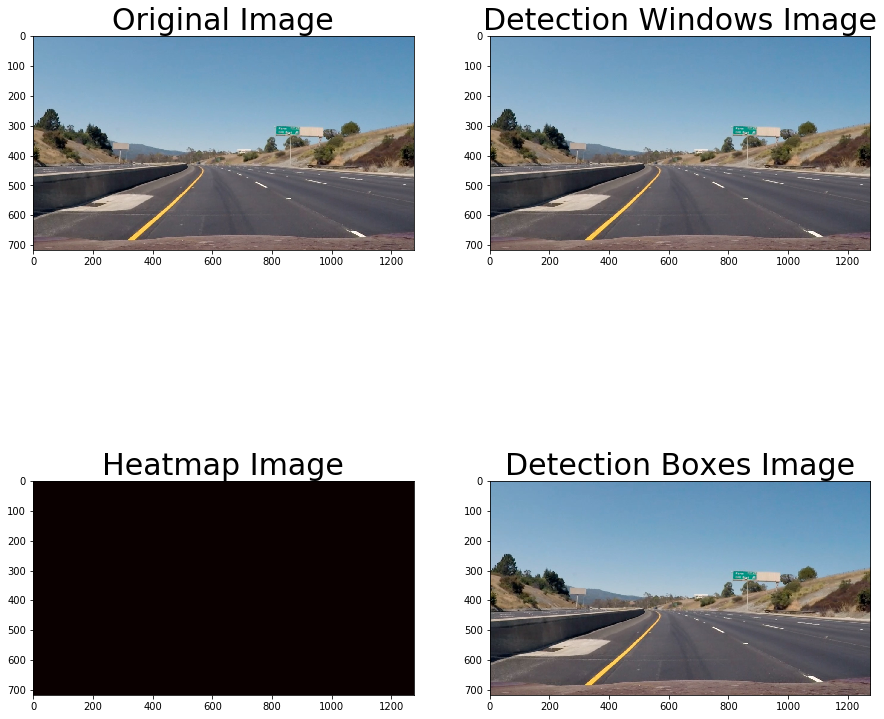

Time to get windows:  2.58
Number of predicted car windows:  0
Total time to mark cars:  2.6


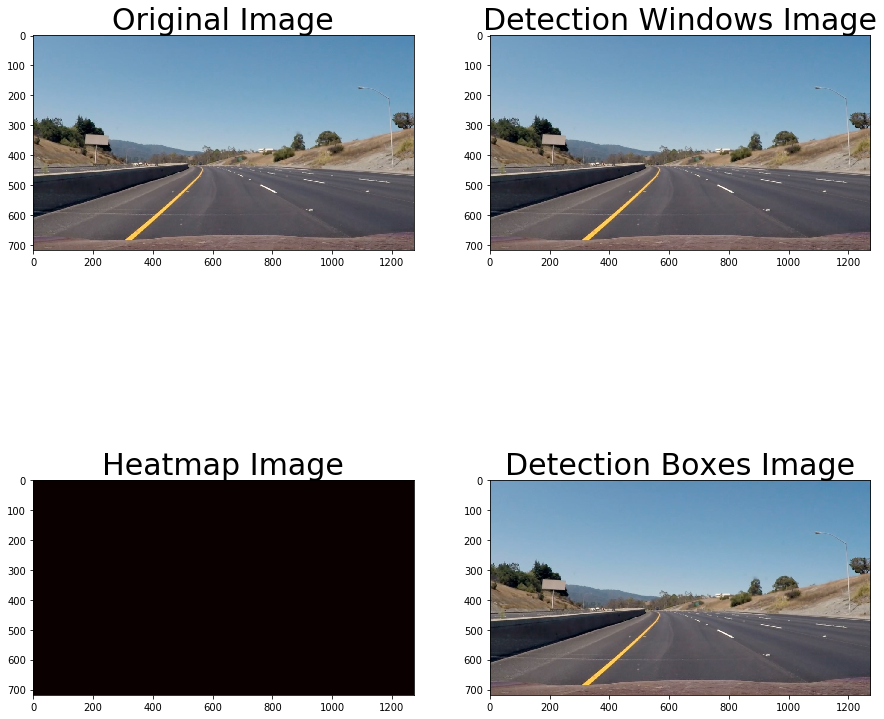

Time to get windows:  2.52
Number of predicted car windows:  0
Total time to mark cars:  2.54


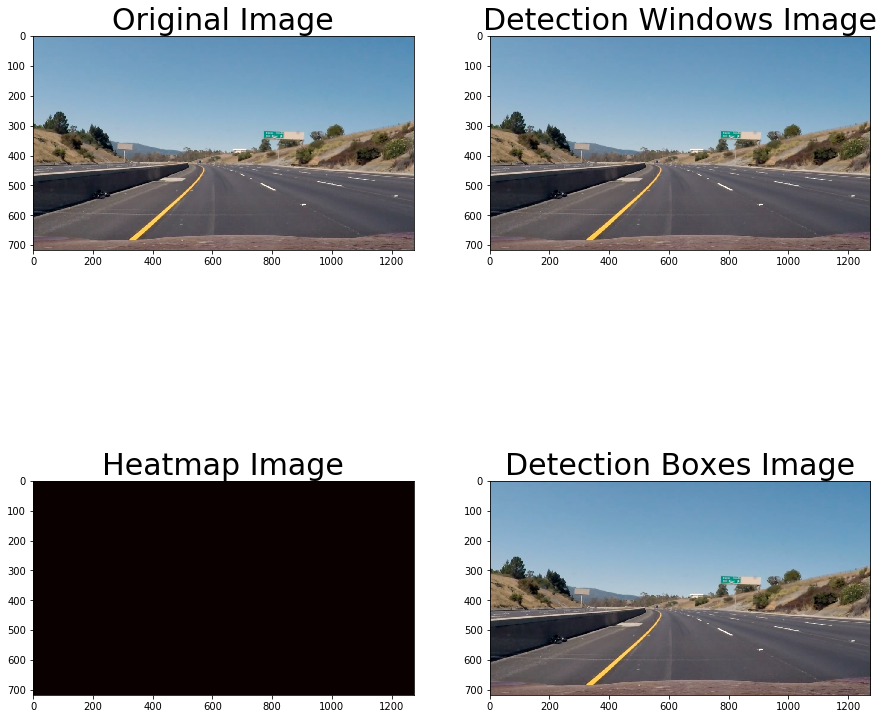

Time to get windows:  2.46
Number of predicted car windows:  2
Total time to mark cars:  2.48


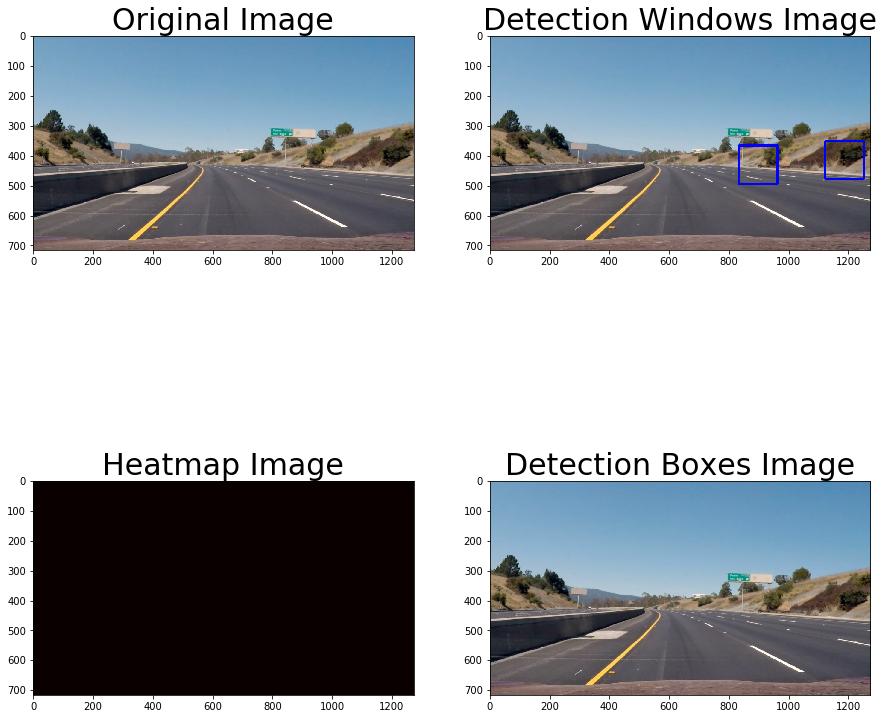

In [5]:
# Read test images
#test_images = glob.glob('test_images/test_false_positives*.jpg')
test_images = glob.glob('test_images/test*.jpg')

for test_image_path in test_images:
    test_image = mpimg.imread(test_image_path)
    
    result = process_single_image(test_image)

In [6]:
from collections import deque

global history
history = deque(maxlen=20)
def process_image(img): 
    global history
    
    windows1 = find_cars(img, 350, 550, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    windows2 = find_cars(img, 300, 660, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    windows = windows1 + windows2
    
    window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
    
    # Add heat to each box in box list
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
    
    history.append(heat)

    #summed_heat = np.sum(history, axis=0)
    averaged_heat = np.sum(history, axis=0) // history.maxlen

    # Apply threshold to help remove false positives
    heat = apply_threshold(averaged_heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(averaged_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)

    return result

Now let's run the pipeline on some videos.

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Test Video

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result_test.mp4'
clip1 = VideoFileClip("test_video.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Test Video 2

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result_test2.mp4'
clip1 = VideoFileClip("test_video2.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Test Video 3

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result_test3.mp4'
clip1 = VideoFileClip("test_video3.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Project Video Trimmed (Check for false positives)

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result_trimmed.mp4'
clip1 = VideoFileClip("project_video_trimmed.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Project Video Trimmed - Check for false positives 2

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result_false_positives.mp4'
clip1 = VideoFileClip("project_video_false_positives.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Project Video

In [ ]:
history = deque(maxlen=20)

In [ ]:
output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))